<a href="https://colab.research.google.com/github/goralex02/time-series-project/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с временными рядами стоимости акций

Контрольное задание
1.	Найти три любых временных ряда, связанных между собой
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за один месяц
2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию
3.	Выбрать в качестве основного один из рядов
4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить
5.	Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q
6.	Построить VAR модель
7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

Дополнительно:
8.	Построить модель на нейронных сетях

Примечание:  Работа должна содержать графики исходных сигналов и результатов моделирования


## 1.	Найти три любых временных ряда, связанных между собой
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за один месяц

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Datetime
0 days 01:00:00    138
0 days 18:00:00     18
2 days 18:00:00      4
Name: count, dtype: int64


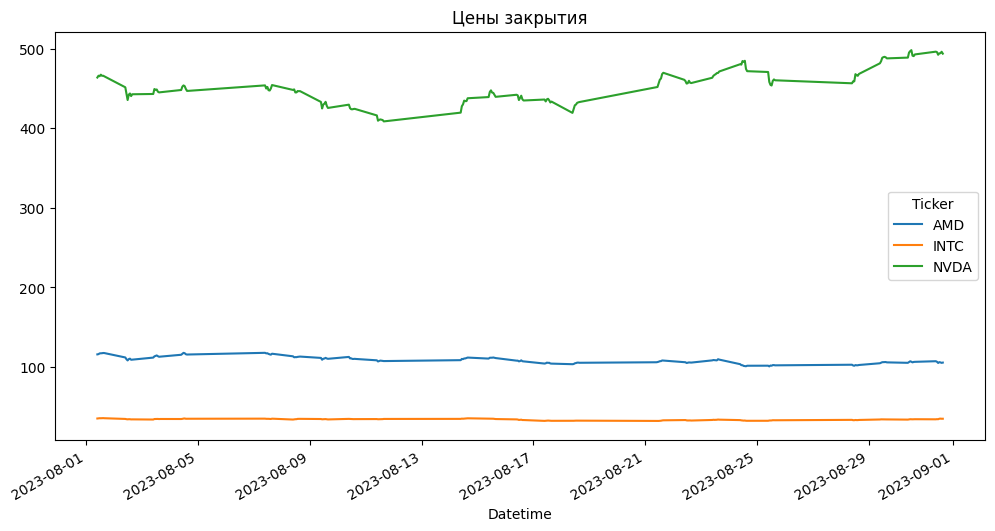

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
tickers = ['NVDA', 'AMD', 'INTC']
data = yf.download(tickers, start='2023-08-01', end='2023-09-01', interval='1h')['Close']

data.index = data.index.tz_convert('America/New_York')
print(data.index.to_series().diff().value_counts())
from pandas.tseries.offsets import CustomBusinessHour
from pandas.tseries.holiday import USFederalHolidayCalendar

# Торговые часы (9:30 - 16:30)
bh = CustomBusinessHour(start='9:30', end='16:30', calendar=USFederalHolidayCalendar())

data = data.asfreq(bh)  # Заполняем недостающие часы



# Визуализация
data.plot(figsize=(12, 6))
plt.title('Цены закрытия')
plt.show()

In [2]:
# Проверим, есть ли даты, которые попадают на выходные
weekends = data.index[data.index.weekday >= 5]  # 5 = суббота, 6 = воскресенье
print(f"Количество записей в выходные: {len(weekends)}")
print(weekends)  # если хочешь увидеть сами даты

Количество записей в выходные: 0
DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Datetime', freq='cbh')


In [3]:
print(data.head())

Ticker                            AMD       INTC        NVDA
Datetime                                                    
2023-08-01 09:30:00-04:00  115.979897  35.459999  463.620087
2023-08-01 10:30:00-04:00  116.290001  35.639999  465.914093
2023-08-01 11:30:00-04:00  117.235001  35.820000  465.299988
2023-08-01 12:30:00-04:00  117.279999  35.775002  467.250000
2023-08-01 13:30:00-04:00  117.440002  35.869999  465.755005


In [4]:
print(data.tail())

Ticker                            AMD       INTC        NVDA
Datetime                                                    
2023-08-31 11:30:00-04:00  105.190002  34.529900  492.239990
2023-08-31 12:30:00-04:00  106.239899  35.154999  494.030212
2023-08-31 13:30:00-04:00  105.879997  35.285000  494.170013
2023-08-31 14:30:00-04:00  105.314499  35.145000  496.010010
2023-08-31 15:30:00-04:00  105.669998  35.150002  493.649994


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2023-08-01 09:30:00-04:00 to 2023-08-31 15:30:00-04:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     161 non-null    float64
 1   INTC    161 non-null    float64
 2   NVDA    161 non-null    float64
dtypes: float64(3)
memory usage: 5.0 KB
None


## 2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию

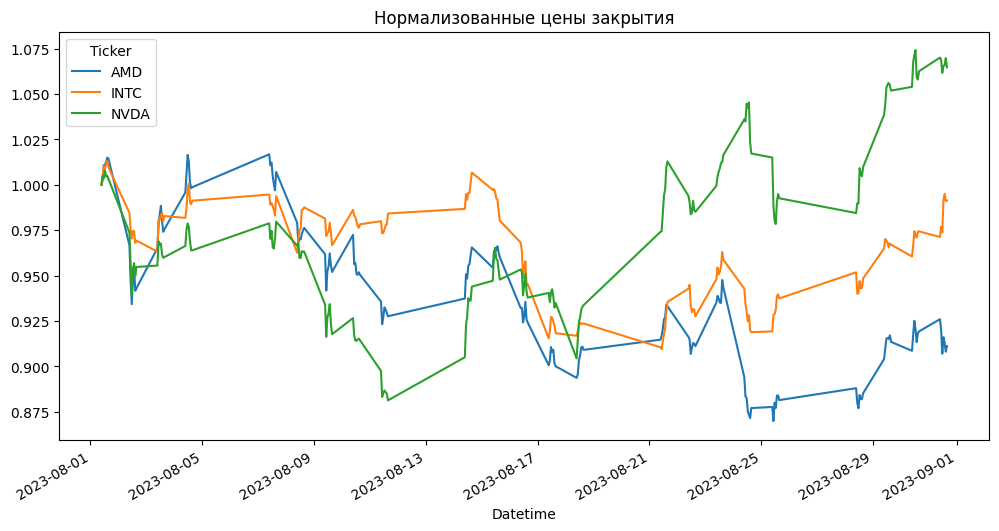

In [6]:
# Нормализация (приведение к одному масштабу, начало с 1)
normalized_data = data / data.iloc[0]
normalized_data.plot(figsize=(12, 6))
plt.title('Нормализованные цены закрытия')
plt.show()

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2023-08-01 09:30:00-04:00 to 2023-08-31 15:30:00-04:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     161 non-null    float64
 1   INTC    161 non-null    float64
 2   NVDA    161 non-null    float64
dtypes: float64(3)
memory usage: 5.0 KB
None


In [8]:
print(data.NVDA.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 161 entries, 2023-08-01 09:30:00-04:00 to 2023-08-31 15:30:00-04:00
Freq: cbh
Series name: NVDA
Non-Null Count  Dtype  
--------------  -----  
161 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB
None


In [9]:
print(data.isnull().sum())

Ticker
AMD     0
INTC    0
NVDA    0
dtype: int64


In [10]:
print(data.duplicated().sum())

0


In [11]:
print(data.describe())

Ticker         AMD        INTC        NVDA
count   161.000000  161.000000  161.000000
mean    108.787339   34.186695  452.446608
std       4.488584    0.958649   22.078484
min     100.879898   32.250000  408.549988
25%     105.610397   33.340000  435.369904
50%     108.220001   34.439999  449.181885
75%     111.742699   34.910000  465.914093
max     117.930000   35.930000  498.035004


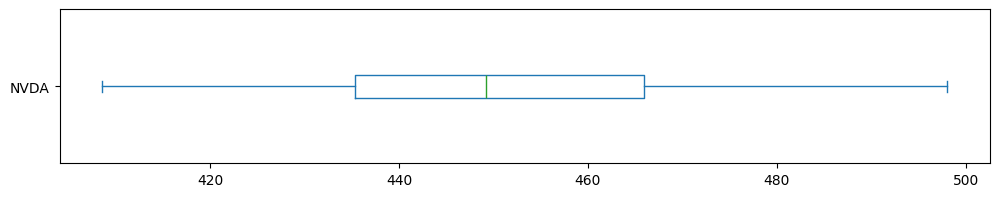

In [12]:
data.NVDA.plot.box(figsize=(12, 2), vert=False);

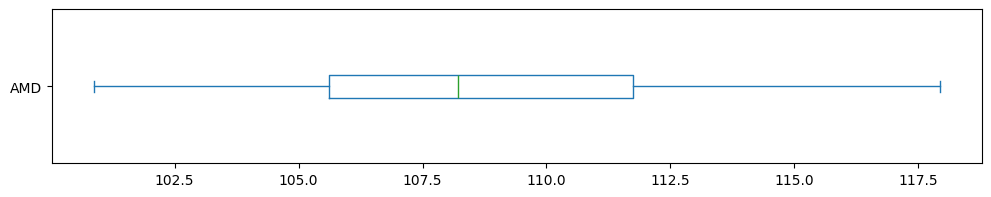

In [13]:
data.AMD.plot.box(figsize=(12, 2), vert=False);

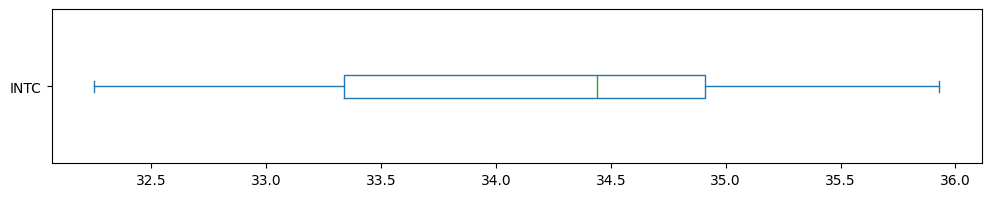

In [14]:
data.INTC.plot.box(figsize=(12, 2), vert=False);

In [15]:
# Корреляционная матрица
corr_matrix = data.corr()
print("Корреляция между рядами:")
print(corr_matrix)


Корреляция между рядами:
Ticker       AMD      INTC      NVDA
Ticker                              
AMD     1.000000  0.773503 -0.239029
INTC    0.773503  1.000000 -0.051289
NVDA   -0.239029 -0.051289  1.000000


In [16]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, name):
    result = adfuller(series)
    print(f"Тест Дики-Фуллера для {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

for col in data.columns:
    test_stationarity(data[col], col)

Тест Дики-Фуллера для AMD:
ADF Statistic: -1.9754901200491748
p-value: 0.2974221325405673
Ряд нестационарен.
Тест Дики-Фуллера для INTC:
ADF Statistic: -1.8341645335028154
p-value: 0.36363666062353783
Ряд нестационарен.
Тест Дики-Фуллера для NVDA:
ADF Statistic: -0.8085687801520116
p-value: 0.8165920858924671
Ряд нестационарен.


In [17]:
data_diff = data.diff().dropna()

for col in data_diff.columns:
    test_stationarity(data_diff[col], f"{col} (дифференцированный)")

Тест Дики-Фуллера для AMD (дифференцированный):
ADF Statistic: -10.913009549241462
p-value: 1.0849372810651082e-19
Ряд стационарен.
Тест Дики-Фуллера для INTC (дифференцированный):
ADF Statistic: -12.57533160630082
p-value: 1.9631275447634628e-23
Ряд стационарен.
Тест Дики-Фуллера для NVDA (дифференцированный):
ADF Statistic: -5.067037561329616
p-value: 1.6324023359579108e-05
Ряд стационарен.


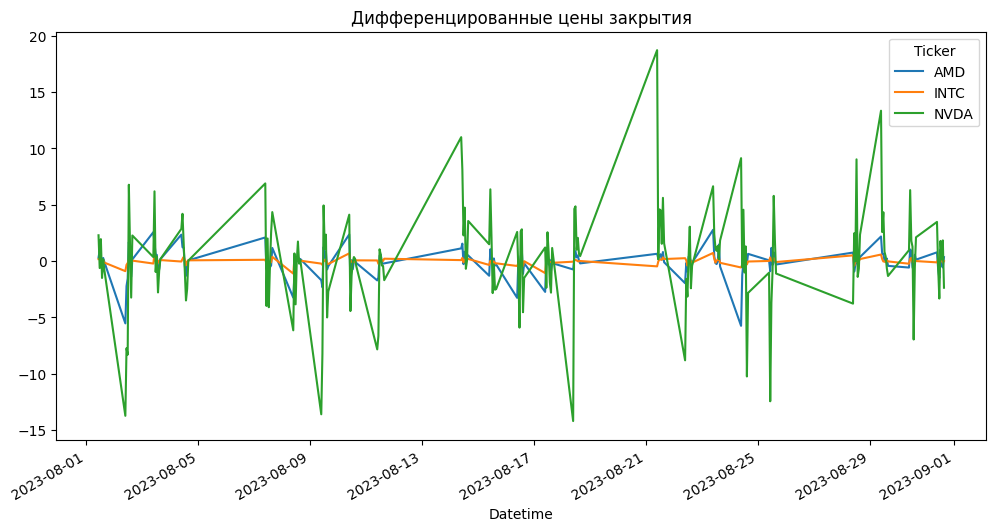

In [18]:
data_diff.plot(figsize=(12, 6))
plt.title('Дифференцированные цены закрытия')
plt.show()

In [59]:
print(data_diff.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 2023-08-01 10:30:00-04:00 to 2023-08-31 15:30:00-04:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     160 non-null    float64
 1   INTC    160 non-null    float64
 2   NVDA    160 non-null    float64
dtypes: float64(3)
memory usage: 5.0 KB
None


In [61]:
print(data_diff.head())

Ticker                          AMD      INTC      NVDA
Datetime                                               
2023-08-01 10:30:00-04:00  0.310104  0.180000  2.294006
2023-08-01 11:30:00-04:00  0.945000  0.180000 -0.614105
2023-08-01 12:30:00-04:00  0.044998 -0.044998  1.950012
2023-08-01 13:30:00-04:00  0.160004  0.094997 -1.494995
2023-08-01 14:30:00-04:00  0.279999  0.060001  0.158386


In [62]:
print(data_diff.tail())

Ticker                          AMD      INTC      NVDA
Datetime                                               
2023-08-31 11:30:00-04:00 -1.504997 -0.110100 -3.320007
2023-08-31 12:30:00-04:00  1.049896  0.625099  1.790222
2023-08-31 13:30:00-04:00 -0.359901  0.130001  0.139801
2023-08-31 14:30:00-04:00 -0.565498 -0.139999  1.839996
2023-08-31 15:30:00-04:00  0.355499  0.005001 -2.360016


In [22]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Загрузка данных (пример)
import pandas as pd

# Тест Йохансена (лаг = 1)
result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Вывод результатов
print("Критические значения (90%, 95%, 99%):\n", result.cvt)
print("Статистики теста:\n", result.lr1)

# Проверка гипотезы о наличии коинтеграции (на уровне 95%)
critical_value_95 = result.cvt[1, 1]  # Вторая строка — 95% уровень
if result.lr1[0] > critical_value_95:
    print("Есть коинтеграция (p < 0.05)")
else:
    print("Нет коинтеграции")

Критические значения (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Статистики теста:
 [1.26957308e+01 3.53122846e+00 4.81506459e-03]
Нет коинтеграции


In [126]:
from statsmodels.tsa.stattools import coint

def test_cointegration(series1, series2, name1, name2):
    score, p_value, _ = coint(series1, series2)
    print(f"Тест коинтеграции между {name1} и {name2}:")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("Ряды коинтегрированы.")
    else:
        print("Ряды не коинтегрированы.")

# Проверка коинтеграции для всех пар
pairs = [('NVDA', 'AMD'), ('NVDA', 'INTC'), ('AMD', 'INTC')]
for pair in pairs:
    test_cointegration(data[pair[0]], data[pair[1]], pair[0], pair[1])

Тест коинтеграции между NVDA и AMD:
p-value: 0.8180133366838498
Ряды не коинтегрированы.
Тест коинтеграции между NVDA и INTC:
p-value: 0.9183404529445545
Ряды не коинтегрированы.
Тест коинтеграции между AMD и INTC:
p-value: 0.8408225908225375
Ряды не коинтегрированы.


## 3.	Выбрать в качестве основного один из рядов

Можно взять AMD (он хорошо коррелирует с INTC и становится стационарным после дифференцирования).


## 4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить

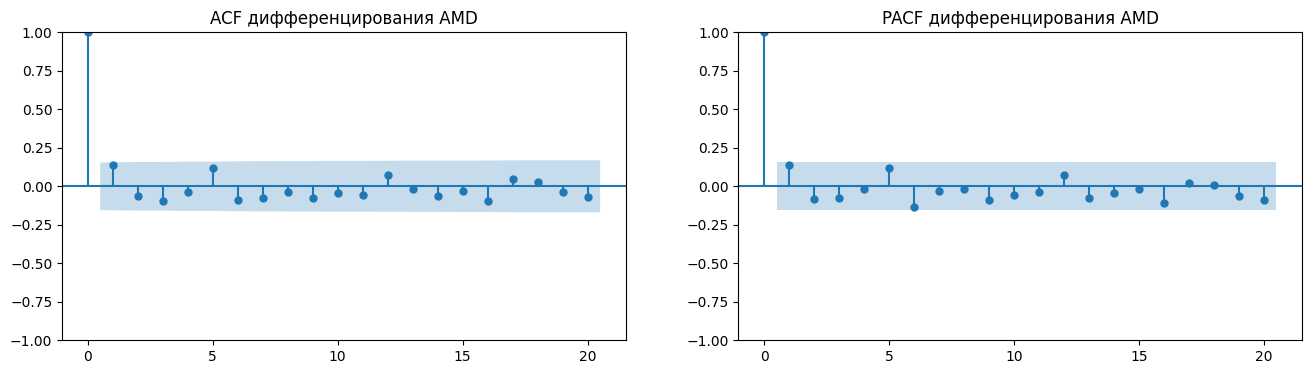

In [86]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# дифференцирование AMD (если еще не сделали)
amd_diff = data_diff['AMD'].dropna()

# Фигура для ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
sm.graphics.tsa.plot_acf(amd_diff, lags=20, ax=axes[0])
axes[0].set_title('ACF дифференцирования AMD')

# PACF
sm.graphics.tsa.plot_pacf(amd_diff, lags=20, ax=axes[1], method='ywm')
axes[1].set_title('PACF дифференцирования AMD')

plt.show()

In [87]:
from statsmodels.tsa.arima.model import ARIMA

# Строим ARIMA модель
model_arima = ARIMA(data_diff['AMD'], order=(1, 0, 1))
result_arima = model_arima.fit()

# Сводка модели
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                    AMD   No. Observations:                  160
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -249.639
Date:                Tue, 18 Mar 2025   AIC                            507.277
Time:                        12:58:24   BIC                            519.578
Sample:                    08-01-2023   HQIC                           512.272
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0641      0.119     -0.540      0.589      -0.296       0.168
ar.L1         -0.2212      0.589     -0.376      0.707      -1.375       0.932
ma.L1          0.3679      0.562      0.655      0.5

Основные параметры:

const (-0.0641): Незначим (p-value = 0.589 → > 0.05). Константу можно исключить из модели.

ar.L1 (-0.2212): Коэффициент AR(1) незначим (p-value = 0.707). Авторегрессионная компонента не улучшает модель.

ma.L1 (0.3679): Коэффициент MA(1) незначим (p-value = 0.513). Скользящее среднее также не вносит вклад.

sigma2 (1.3264): Дисперсия ошибок модели.

Качество модели:

AIC = 507.27, BIC = 519.57: Высокие значения указывают на слабое качество модели.

Ljung-Box (Q): p-value = 1.00 → остатки не имеют автокорреляции (хорошо).

Jarque-Bera: p-value = 0.00 → остатки не нормальны (проблема).

Куртозис (8.82): Распределение остатков имеет "тяжелые хвосты" (выбросы).

Вывод:
Модель ARIMA(1,0,1) неадекватна:

Параметры AR и MA незначимы.

Остатки ненормальны, есть выбросы.

In [88]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Берем регрессоры
exog = data_diff[['INTC', 'NVDA']]

# Строим ARIMAX модель
model_arimax = SARIMAX(data_diff['AMD'], exog=exog, order=(1, 0, 1))
result_arimax = model_arimax.fit()

# Сводка модели
print(result_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                    AMD   No. Observations:                  160
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -180.296
Date:                Tue, 18 Mar 2025   AIC                            370.592
Time:                        12:58:24   BIC                            385.968
Sample:                    08-01-2023   HQIC                           376.836
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INTC           2.6621      0.189     14.118      0.000       2.293       3.032
NVDA           0.0826      0.010      8.017      0.000       0.062       0.103
ar.L1         -0.4708      1.537     -0.306      0.7

Основные параметры:

INTC (2.6621): Значим (p-value < 0.001). Увеличение INTC на 1 единицу ведет к росту AMD на ~2.66 единиц.

NVDA (0.0826): Значим (p-value < 0.001). Увеличение NVDA на 1 единицу ведет к росту AMD на ~0.08 единиц.

ar.L1 (-0.4708) и ma.L1 (0.5212): Незначимы (p-value > 0.7). AR и MA компоненты избыточны.

sigma2 (0.5575): Дисперсия ошибок ниже, чем в ARIMA → модель точнее.

Качество модели:

AIC = 370.59, BIC = 385.96: Значительно ниже, чем у ARIMA → модель лучше.

Ljung-Box (Q): p-value = 0.69 → остатки не имеют автокорреляции (хорошо).

Jarque-Bera: p-value = 0.00 → остатки не нормальны (сильная асимметрия и куртозис).

Куртозис (16.31): Экстремальные выбросы в остатках.

Вывод:
Модель ARIMAX лучше ARIMA, но требует доработки:

Экзогенные переменные (INTC, NVDA) значимы и улучшают прогноз.

AR и MA параметры можно исключить (упростить модель).

Проблема с нормальностью остатков требует внимания.

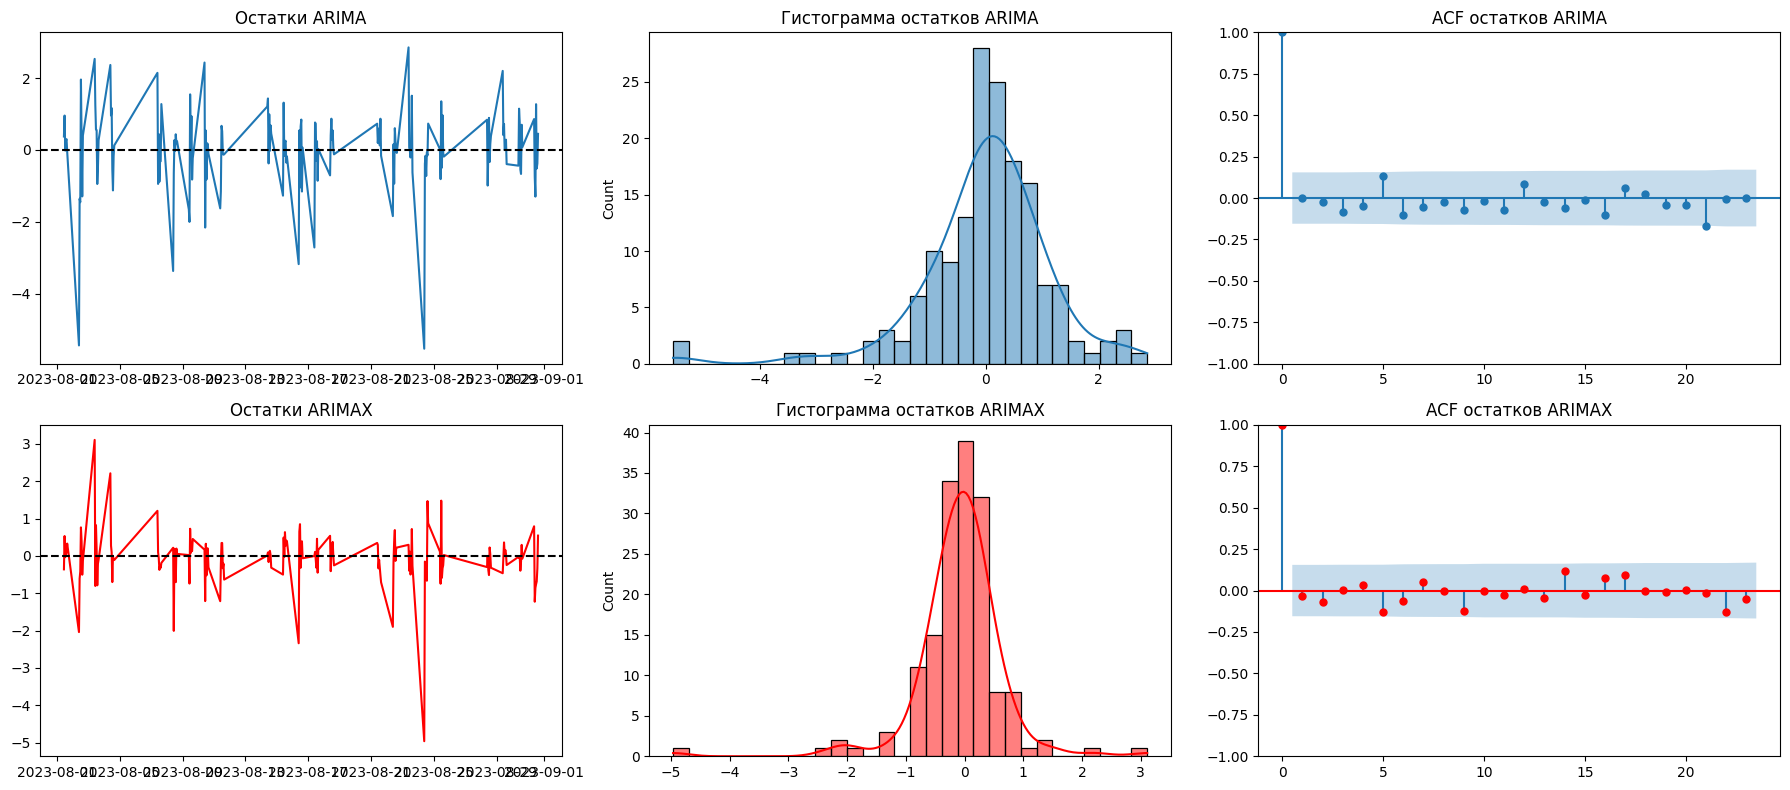

In [89]:
import seaborn as sns
import statsmodels.api as sm
# Получаем остатки модели
residuals_arima = result_arima.resid
residuals_arimax = result_arimax.resid

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# 1. Временной ряд остатков ARIMA
axes[0, 0].plot(residuals_arima, label="Остатки ARIMA")
axes[0, 0].axhline(0, linestyle="--", color="black")
axes[0, 0].set_title("Остатки ARIMA")

# 2. Гистограмма остатков ARIMA
sns.histplot(residuals_arima, bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Гистограмма остатков ARIMA")

# 3. ACF остатков ARIMA
sm.graphics.tsa.plot_acf(residuals_arima, ax=axes[0, 2])
axes[0, 2].set_title("ACF остатков ARIMA")

# 4. Временной ряд остатков ARIMAX
axes[1, 0].plot(residuals_arimax, label="Остатки ARIMAX", color="red")
axes[1, 0].axhline(0, linestyle="--", color="black")
axes[1, 0].set_title("Остатки ARIMAX")

# 5. Гистограмма остатков ARIMAX
sns.histplot(residuals_arimax, bins=30, kde=True, ax=axes[1, 1], color="red")
axes[1, 1].set_title("Гистограмма остатков ARIMAX")

# 6. ACF остатков ARIMAX
sm.graphics.tsa.plot_acf(residuals_arimax, ax=axes[1, 2], color='red')
axes[1, 2].set_title("ACF остатков ARIMAX")

plt.tight_layout()
plt.show()

In [90]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Для ARIMA
lb_test_arima = acorr_ljungbox(residuals_arima, lags=10)
print("ARIMA p-values:", lb_test_arima.iloc[:, 1].values)

# Для ARMAX
lb_test_armax = acorr_ljungbox(residuals_arimax, lags=10)
print("ARMAX p-values:", lb_test_armax.iloc[:, 1].values)

ARIMA p-values: [0.996335   0.96235081 0.72401962 0.79491709 0.44825793 0.37974515
 0.44076997 0.53881425 0.54721837 0.63511702]
ARMAX p-values: [0.69222259 0.63400157 0.82195132 0.89239367 0.57502563 0.6100314
 0.66874535 0.76497152 0.58727519 0.67898736]


 Все p-values > 0.05 → остатки не имеют автокорреляции.

In [91]:
# Разделение на train/test
train_size = 130
train, test = data_diff['AMD'][:train_size], data_diff['AMD'][train_size:]

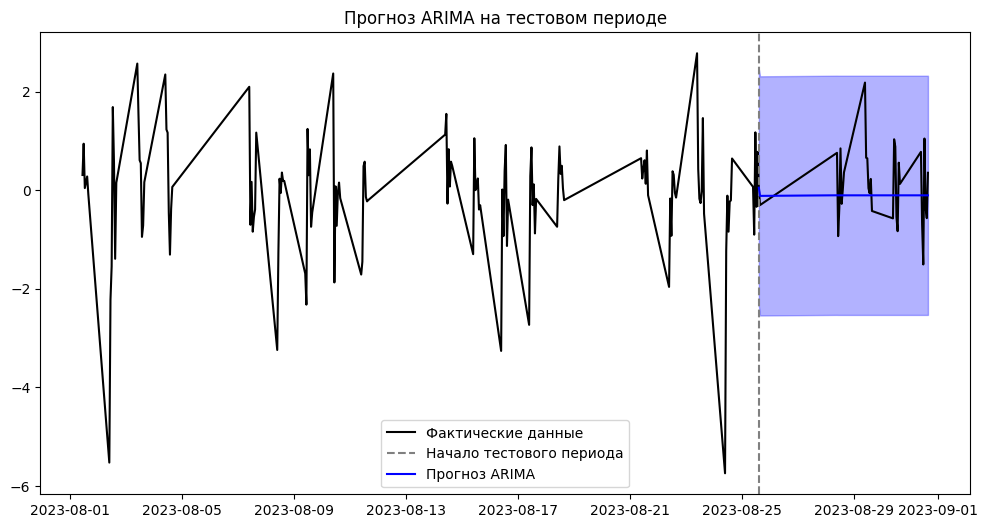

In [92]:
# Обучаем ARIMA только на train (без регрессоров)
model_arima_train = ARIMA(train, order=(1, 0, 1))
result_arima_train = model_arima_train.fit()

# Делаем прогноз на тестовые данные
forecast_arima = result_arima_train.get_forecast(steps=len(test))
forecast_arima_mean = forecast_arima.predicted_mean
forecast_arima_ci = forecast_arima.conf_int()

# Визуализация прогноза ARIMA
plt.figure(figsize=(12, 6))
plt.plot(data_diff.index, data_diff['AMD'], label="Фактические данные", color="black")
plt.axvline(data_diff.index[train_size], linestyle="--", color="gray", label="Начало тестового периода")
plt.plot(test.index, forecast_arima_mean, label="Прогноз ARIMA", color="blue")
plt.fill_between(test.index, forecast_arima_ci.iloc[:, 0], forecast_arima_ci.iloc[:, 1], color="blue", alpha=0.3)
plt.legend()
plt.title("Прогноз ARIMA на тестовом периоде")
plt.show()


Константный прогноз — это следствие:

Незначимых AR/MA параметров.

Стационарности данных.

In [93]:
from sklearn.metrics import mean_absolute_error
import numpy as np
mae_arima = mean_absolute_error(test, forecast_arima_mean)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima_mean))

print(f"MAE ARIMA: {mae_arima:.4f}")
print(f"RMSE ARIMA: {rmse_arima:.4f}")

MAE ARIMA: 0.6124
RMSE ARIMA: 0.7730


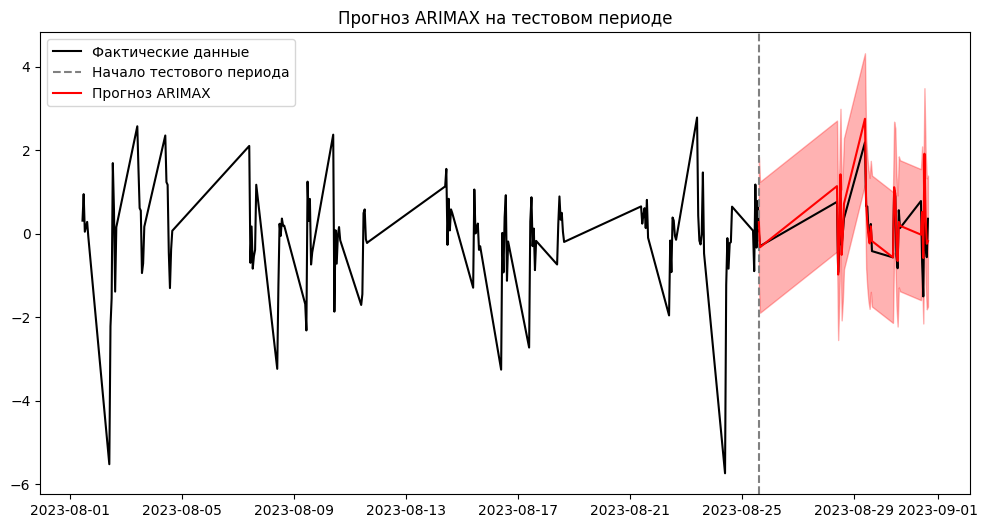

In [94]:
# Обучаем ARIMAX только на train
exog_train, exog_test = data_diff[['INTC', 'NVDA']][:train_size], data_diff[['INTC', 'NVDA']][train_size:]
model_arimax_train = SARIMAX(train, exog=exog_train, order=(1, 0, 1))
result_arimax_train = model_arimax_train.fit()

# Делаем прогноз на тест
forecast = result_arimax_train.get_forecast(steps=len(test), exog=exog_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(data_diff.index, data_diff['AMD'], label="Фактические данные", color="black")
plt.axvline(data_diff.index[train_size], linestyle="--", color="gray", label="Начало тестового периода")
plt.plot(test.index, forecast_mean, label="Прогноз ARIMAX", color="red")
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="red", alpha=0.3)
plt.legend()
plt.title("Прогноз ARIMAX на тестовом периоде")
plt.show()

In [95]:
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.3436
RMSE: 0.4596


Благодаря экзогенным переменным ARIMAX корректнее предсказывает значения ряда

## 5.	Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q

## 6.	Построить VAR модель

## 7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

## 8.	Построить модель на нейронных сетях